In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import zipfile
import subprocess
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchsummary
import numpy as np
from PIL import Image
from PIL import ImageFile
import json
import cv2
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import random

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def seed_everything(seed=42):
    """
    모든 랜덤 시드를 주어진 값으로 고정합니다.
    """
    random.seed(seed)  # Python random 모듈
    np.random.seed(seed)  # Numpy 랜덤 시드
    torch.manual_seed(seed)  # PyTorch 랜덤 시드
    torch.cuda.manual_seed(seed)  # GPU를 위한 PyTorch 랜덤 시드
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 위한 PyTorch 랜덤 시드

seed_everything()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_zip_paths, label_zip_paths, cache_dir, transform=None, workers=4):
        super().__init__()
        self.image_zip_paths = image_zip_paths
        self.label_zip_paths = label_zip_paths
        self.cache_dir = cache_dir
        self.transform = transform
        self.workers = workers

        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir, exist_ok=True)

        self.image_names = {}
        self.label_names = {}
        self.image_list = []

        self._prepare()

    def _extract_and_cache(self, zip_path, file_name, cache_file_path, attempts=3):
        if os.path.exists(cache_file_path):
            return True

        command = ["unzip", "-o", zip_path, file_name, "-d", os.path.dirname(cache_file_path)]

        for attempt in range(attempts):
            result = subprocess.run(command, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # 성공적으로 압축 해제되었거나, 경고만 있는 경우
            if result.returncode == 0 or "warning" in result.stderr.decode().lower():
                return True
            else:
                # 오류 메시지가 있고, 재시도 횟수가 남아있는 경우
                print(f"Attempt {attempt + 1}: Error unzipping file => {zip_path}")
                time.sleep(2 ** attempt)

        # 모든 시도가 실패한 경우
        print(f"Failed to extract {file_name}")
        return False

    def _prepare(self):
        max_tries = 3
        wait_seconds = 10

        # 각 zip 파일에 대한 재시도 횟수를 추적
        retries = {zip_path: 0 for zip_path in self.image_zip_paths + self.label_zip_paths}

        # 전체 압축 파일 리스트
        to_process = [(zip_path, '.png') for zip_path in self.image_zip_paths] + [(zip_path, '.json') for zip_path in self.label_zip_paths]

        while to_process:
            # 병렬처리
            with ThreadPoolExecutor(max_workers=self.workers) as executor:
                future_to_zip_path = {
                    executor.submit(self._process_zip, zip_path, file_extension): (zip_path, file_extension)
                    for zip_path, file_extension in to_process
                }

                # 처리 중 예외 발생 시 재시도할 작업 목록
                to_retry = []

                # future 객체의 작업완료 상황을 모니터링
                for future in as_completed(future_to_zip_path):
                    zip_path, file_extension = future_to_zip_path[future]

                    try:
                        success = future.result()
                        if not success:
                            raise Exception(f"Failed to process {zip_path}")

                    except OSError as e: # 구글드라이브와의 연결로 인한 예외처리
                        if e.errno == 107 and retries[zip_path] < max_tries:
                            print(f"OSError [Errno 107] => {zip_path}")
                            to_retry.append((zip_path, file_extension))
                            retries[zip_path] += 1
                            time.sleep(wait_seconds)  # 각 재시도 사이에 대기
                            wait_seconds *= 2  # 대기 시간 증가
                        else:
                            print(f"Unexpected Error : {zip_path}: {e}")

                    except Exception as e:
                        print(f"Exception processing {zip_path}: {e}")

                # 재시도할 작업이 있으면 to_process 업데이트
                to_process = to_retry if to_retry else []

        self.image_list = sorted(self.image_names.keys())

    def _process_zip(self, zip_path, file_extension):
        success = True
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:

            for file_name in sorted(zip_ref.namelist()):

                if file_name.endswith(file_extension):
                    base_name = os.path.splitext(os.path.basename(file_name))[0].lstrip('_')  # 확장자 제외 파일 기본 이름

                    # 데이터 접근시 사용할 경로
                    cache_file_path = os.path.join(self.cache_dir, os.path.basename(zip_path).replace('.zip', ''), file_name.replace('/', '_').lstrip('_'))

                    if file_extension == '.png':
                        self.image_names[base_name.lower()] = cache_file_path
                    else:
                        self.label_names[base_name.lower()] = cache_file_path

                    extract_success = self._extract_and_cache(zip_path, file_name, cache_file_path)
                    success = success and extract_success

        return success

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # 파일 이름을 키 리스트에서 추출
        base_name = self.image_list[idx]

        image_path = self.image_names.get(base_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            return None

        label_path = self.label_names.get(base_name)
        with open(label_path, 'r') as f:
            label_data = json.load(f)

        age_past = label_data['age_past']
        gender = label_data['gender']
        box = label_data['annotation'][0]['box']

        image = image.crop((box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']))

        if self.transform:
            image = self.transform(image)

        gender_label = 0 if gender == 'male' else 1

        label = {'age_past': age_past, 'gender': gender_label}

        return image, label


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561))
])

In [ ]:
def get_zip_files(directory):
    return [os.path.join(directory, zip) for zip in os.listdir(directory) if zip.endswith('.zip')] # 리스트를 정렬하면 속도 하락

train_images = '/content/drive/MyDrive/DL_Project/data/Training/image'
train_labels = '/content/drive/MyDrive/DL_Project/data/Training/label'
train_cache = '/content/cache/train'

val_images = '/content/drive/MyDrive/DL_Project/data/Validation/image'
val_labels = '/content/drive/MyDrive/DL_Project/data/Validation/label'
val_cache = '/content/cache/val'

train_image_zips = get_zip_files(train_images)
train_label_zips = get_zip_files(train_labels)
val_image_zips = get_zip_files(val_images)
val_label_zips = get_zip_files(val_labels)

In [ ]:
train_image_zips[:3]

['/content/drive/MyDrive/DL_Project/data/Training/image/TS_0805.zip',
 '/content/drive/MyDrive/DL_Project/data/Training/image/TS_0631.zip',
 '/content/drive/MyDrive/DL_Project/data/Training/image/TS_0576.zip']

In [ ]:
len(train_image_zips)

803

In [ ]:
%time train_dataset = CustomDataset(train_image_zips, train_label_zips, train_cache, transform_train)

CPU times: user 37.8 s, sys: 18.9 s, total: 56.7 s
Wall time: 32min 10s


In [ ]:
len(train_dataset)

40150

In [ ]:
%time val_dataset = CustomDataset(val_image_zips, val_label_zips, val_cache, transform_val)

CPU times: user 4.32 s, sys: 2.3 s, total: 6.62 s
Wall time: 3min 1s


In [ ]:
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    prefetch_factor=4
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    num_workers=2,
    prefetch_factor=4
)

In [ ]:
x, y = next(iter(train_loader))
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
y['age_past'].shape, y['gender'].shape

(torch.Size([64]), torch.Size([64]))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class Gender_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        # average pooling
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        x = x.squeeze()
        return x

In [ ]:
gender_model = Gender_Net().to(device)
torchsummary.summary(gender_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 64, 108, 108]          18,496
       BatchNorm2d-5         [-1, 64, 108, 108]             128
         MaxPool2d-6           [-1, 64, 53, 53]               0
            Conv2d-7          [-1, 128, 51, 51]          73,856
       BatchNorm2d-8          [-1, 128, 51, 51]             256
         MaxPool2d-9          [-1, 128, 25, 25]               0
           Conv2d-10          [-1, 256, 23, 23]         295,168
      BatchNorm2d-11          [-1, 256, 23, 23]             512
        MaxPool2d-12          [-1, 256, 11, 11]               0
           Conv2d-13            [-1, 512, 9, 9]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)
gender_lr_scheduler = ReduceLROnPlateau(opt_gender, mode='min', verbose=True)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:
def save_model(epoch, model, optimizer, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

In [ ]:
# 모델 이어서 학습
def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [ ]:
def train_loop_gender(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    start_time = time.time()  # 에포크 시작 시간

    for batch, (x, y) in enumerate(dataloader):
        batch_start_time = time.time()  # 배치 처리 시작 시간
        x, y = x.to(device), y['gender'].float().to(device)
        pred = model(x)
        loss = loss_fn(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        batch_process_time = time.time() - batch_start_time

        if batch % 10 == 0:
            processed = (batch + 1) * len(x)
            print(f'Epoch {epoch+1} : [{processed} / {size}] loss : {loss.item()}, Batch time: {batch_process_time:.4f} sec')

    average_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} finished, Total Epoch time: {epoch_time:.4f} sec")
    return average_loss


In [ ]:
def validation_loop_gender(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    correct = 0.0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    val_loss /= len(dataloader)
    return val_loss

In [ ]:
start = time.time()
for epoch in range(30):
    gender_loss = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v2_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v2_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1 : [256 / 40150] loss : 0.688152551651001, Batch time: 1.4390 sec
Epoch 1 : [2816 / 40150] loss : 0.6929473280906677, Batch time: 0.6499 sec
Epoch 1 : [5376 / 40150] loss : 0.6811827421188354, Batch time: 0.6469 sec
Epoch 1 : [7936 / 40150] loss : 0.6720981597900391, Batch time: 0.6683 sec
Epoch 1 : [10496 / 40150] loss : 0.6572595238685608, Batch time: 0.6481 sec
Epoch 1 : [13056 / 40150] loss : 0.6638097167015076, Batch time: 0.6635 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [15616 / 40150] loss : 0.6432533264160156, Batch time: 0.6643 sec
Epoch 1 : [18176 / 40150] loss : 0.6566208600997925, Batch time: 0.6535 sec
Epoch 1 : [20736 / 40150] loss : 0.6444728374481201, Batch time: 0.6435 sec
Epoch 1 : [23296 / 40150] loss : 0.6269081830978394, Batch time: 0.6595 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [25856 / 40150] loss : 0.6020354628562927, Batch time: 0.6404 sec
Epoch 1 : [28416 / 40150] loss : 0.6023403406143188, Batch time: 0.6198 sec
Epoch 1 : [30976 / 40150] loss : 0.5329421758651733, Batch time: 0.6242 sec
Epoch 1 : [33536 / 40150] loss : 0.5734043717384338, Batch time: 0.6216 sec
Epoch 1 : [36096 / 40150] loss : 0.6102896332740784, Batch time: 0.6210 sec
Epoch 1 : [38656 / 40150] loss : 0.5841919183731079, Batch time: 0.6217 sec
Epoch 1 finished, Total Epoch time: 1577.2343 sec
Epoch : 1, Loss : 0.6635311443334931, Val_loss : 0.5817230224609375
Epoch 2 : [256 / 40150] loss : 0.5991553068161011, Batch time: 0.6407 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [2816 / 40150] loss : 0.5514862537384033, Batch time: 0.6671 sec
Epoch 2 : [5376 / 40150] loss : 0.5756694078445435, Batch time: 0.6705 sec
Epoch 2 : [7936 / 40150] loss : 0.5513640642166138, Batch time: 0.6512 sec
Epoch 2 : [10496 / 40150] loss : 0.5299692153930664, Batch time: 0.6698 sec
Epoch 2 : [13056 / 40150] loss : 0.533241331577301, Batch time: 0.6707 sec
Epoch 2 : [15616 / 40150] loss : 0.5551862716674805, Batch time: 0.6658 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [18176 / 40150] loss : 0.5526271462440491, Batch time: 0.6595 sec
Epoch 2 : [20736 / 40150] loss : 0.5324683785438538, Batch time: 0.6552 sec
Epoch 2 : [23296 / 40150] loss : 0.556088924407959, Batch time: 0.6677 sec
Epoch 2 : [25856 / 40150] loss : 0.48642170429229736, Batch time: 0.6597 sec
Epoch 2 : [28416 / 40150] loss : 0.5362202525138855, Batch time: 0.6831 sec
Epoch 2 : [30976 / 40150] loss : 0.4931318759918213, Batch time: 0.6755 sec
Epoch 2 : [33536 / 40150] loss : 0.4957834780216217, Batch time: 0.6687 sec
Epoch 2 : [36096 / 40150] loss : 0.5152133107185364, Batch time: 0.6649 sec
Epoch 2 : [38656 / 40150] loss : 0.531804084777832, Batch time: 0.6691 sec
Epoch 2 finished, Total Epoch time: 1564.6810 sec
Epoch : 2, Loss : 0.5445629314632173, Val_loss : 0.5021642498672009
Epoch 3 : [256 / 40150] loss : 0.5377620458602905, Batch time: 0.6575 sec
Epoch 3 : [2816 / 40150] loss : 0.5047324895858765, Batch time: 0.6800 sec
Epoch 3 : [5376 / 40150] loss : 0.5277926921844482

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [28416 / 40150] loss : 0.4699099063873291, Batch time: 0.6681 sec
Epoch 3 : [30976 / 40150] loss : 0.5126198530197144, Batch time: 0.6671 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [33536 / 40150] loss : 0.4812307357788086, Batch time: 0.6803 sec
Epoch 3 : [36096 / 40150] loss : 0.5115289688110352, Batch time: 0.6734 sec
Epoch 3 : [38656 / 40150] loss : 0.5551421642303467, Batch time: 0.6866 sec
Epoch 3 finished, Total Epoch time: 1563.0918 sec
Epoch : 3, Loss : 0.5067673828571465, Val_loss : 0.47848252281546594
Epoch 4 : [256 / 40150] loss : 0.5187238454818726, Batch time: 0.6774 sec
Epoch 4 : [2816 / 40150] loss : 0.4582853317260742, Batch time: 0.6890 sec
Epoch 4 : [5376 / 40150] loss : 0.49408194422721863, Batch time: 0.6817 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 : [7936 / 40150] loss : 0.46490049362182617, Batch time: 0.6706 sec
Epoch 4 : [10496 / 40150] loss : 0.49214816093444824, Batch time: 0.6757 sec
Epoch 4 : [13056 / 40150] loss : 0.4895370304584503, Batch time: 0.6791 sec
Epoch 4 : [15616 / 40150] loss : 0.473158061504364, Batch time: 0.6577 sec
Epoch 4 : [18176 / 40150] loss : 0.4967469871044159, Batch time: 0.6603 sec
Epoch 4 : [20736 / 40150] loss : 0.4855228662490845, Batch time: 0.6614 sec
Epoch 4 : [23296 / 40150] loss : 0.49713894724845886, Batch time: 0.6560 sec
Epoch 4 : [25856 / 40150] loss : 0.4592639207839966, Batch time: 0.6602 sec
Epoch 4 : [28416 / 40150] loss : 0.5425068140029907, Batch time: 0.6588 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 : [30976 / 40150] loss : 0.45984405279159546, Batch time: 0.6600 sec
Epoch 4 : [33536 / 40150] loss : 0.5247519016265869, Batch time: 0.6853 sec
Epoch 4 : [36096 / 40150] loss : 0.4952442944049835, Batch time: 0.6597 sec
Epoch 4 : [38656 / 40150] loss : 0.4986727833747864, Batch time: 0.6580 sec
Epoch 4 finished, Total Epoch time: 1541.2089 sec
Epoch : 4, Loss : 0.48735550121896587, Val_loss : 0.46412837989628314
Epoch 5 : [256 / 40150] loss : 0.44069215655326843, Batch time: 0.6850 sec
Epoch 5 : [2816 / 40150] loss : 0.4494898021221161, Batch time: 0.6786 sec
Epoch 5 : [5376 / 40150] loss : 0.44757962226867676, Batch time: 0.6782 sec
Epoch 5 : [7936 / 40150] loss : 0.45630455017089844, Batch time: 0.6837 sec
Epoch 5 : [10496 / 40150] loss : 0.4397695064544678, Batch time: 0.6775 sec
Epoch 5 : [13056 / 40150] loss : 0.4471176862716675, Batch time: 0.6821 sec
Epoch 5 : [15616 / 40150] loss : 0.49895814061164856, Batch time: 0.6740 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 : [18176 / 40150] loss : 0.516582727432251, Batch time: 0.6775 sec
Epoch 5 : [20736 / 40150] loss : 0.46125534176826477, Batch time: 0.6816 sec
Epoch 5 : [23296 / 40150] loss : 0.46953871846199036, Batch time: 0.6833 sec
Epoch 5 : [25856 / 40150] loss : 0.4900972247123718, Batch time: 0.6795 sec
Epoch 5 : [28416 / 40150] loss : 0.519076406955719, Batch time: 0.6865 sec
Epoch 5 : [30976 / 40150] loss : 0.4923788607120514, Batch time: 0.6933 sec
Epoch 5 : [33536 / 40150] loss : 0.5124272108078003, Batch time: 0.6753 sec
Epoch 5 : [36096 / 40150] loss : 0.44727444648742676, Batch time: 0.6908 sec
Epoch 5 : [38656 / 40150] loss : 0.4653981626033783, Batch time: 0.6570 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 finished, Total Epoch time: 1572.6319 sec
Epoch : 5, Loss : 0.4692690947632881, Val_loss : 0.44474241361021993
Epoch 6 : [256 / 40150] loss : 0.4608768820762634, Batch time: 0.6724 sec
Epoch 6 : [2816 / 40150] loss : 0.45206713676452637, Batch time: 0.6946 sec
Epoch 6 : [5376 / 40150] loss : 0.48472627997398376, Batch time: 0.6830 sec
Epoch 6 : [7936 / 40150] loss : 0.4625355005264282, Batch time: 0.6939 sec
Epoch 6 : [10496 / 40150] loss : 0.44536465406417847, Batch time: 0.6713 sec
Epoch 6 : [13056 / 40150] loss : 0.4628787934780121, Batch time: 0.6796 sec
Epoch 6 : [15616 / 40150] loss : 0.42572543025016785, Batch time: 0.6735 sec
Epoch 6 : [18176 / 40150] loss : 0.4001563489437103, Batch time: 0.6712 sec
Epoch 6 : [20736 / 40150] loss : 0.46347111463546753, Batch time: 0.6870 sec
Epoch 6 : [23296 / 40150] loss : 0.48443764448165894, Batch time: 0.6751 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 : [25856 / 40150] loss : 0.44385427236557007, Batch time: 0.6815 sec
Epoch 6 : [28416 / 40150] loss : 0.44671422243118286, Batch time: 0.6707 sec
Epoch 6 : [30976 / 40150] loss : 0.4494606852531433, Batch time: 0.6843 sec
Epoch 6 : [33536 / 40150] loss : 0.4748446047306061, Batch time: 0.6808 sec
Epoch 6 : [36096 / 40150] loss : 0.4205334186553955, Batch time: 0.6888 sec
Epoch 6 : [38656 / 40150] loss : 0.450862318277359, Batch time: 0.6772 sec
Epoch 6 finished, Total Epoch time: 1555.8710 sec
Epoch : 6, Loss : 0.4514427697582609, Val_loss : 0.44195200577378274
Epoch 7 : [256 / 40150] loss : 0.4125579595565796, Batch time: 0.6739 sec
Epoch 7 : [2816 / 40150] loss : 0.4433913230895996, Batch time: 0.6890 sec
Epoch 7 : [5376 / 40150] loss : 0.4255070686340332, Batch time: 0.6894 sec
Epoch 7 : [7936 / 40150] loss : 0.4604700207710266, Batch time: 0.6780 sec
Epoch 7 : [10496 / 40150] loss : 0.39572441577911377, Batch time: 0.6743 sec


- Epoch : 1, Loss : 0.6635311443334931, Val_loss : 0.5817230224609375
- Epoch : 2, Loss : 0.5445629314632173, Val_loss : 0.5021642498672009
- Epoch : 3, Loss : 0.5067673828571465, Val_loss : 0.47848252281546594
- Epoch : 4, Loss : 0.48735550121896587, Val_loss : 0.46412837989628314
- Epoch : 5, Loss : 0.4692690947632881, Val_loss : 0.44474241361021993
- Epoch : 6, Loss : 0.4514427697582609, Val_loss : 0.44195200577378274
- Epoch : 7, Loss : 0.440453033538381, Val_loss : 0.43259060829877855

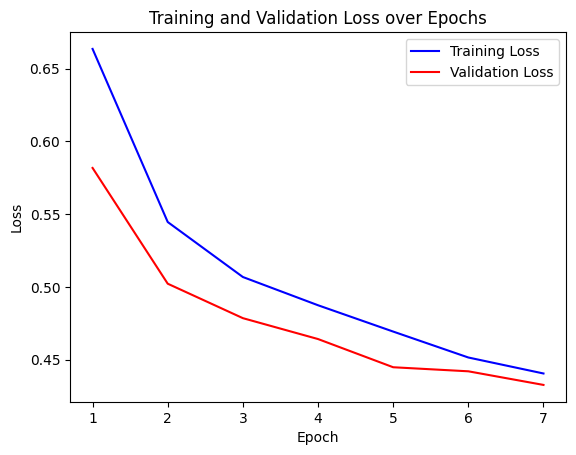

In [ ]:
import matplotlib.pyplot as plt

# loss와 val_loss를 저장할 리스트
losses = [0.66353, 0.54456,  0.50676, 0.48735, 0.46926, 0.45144,0.44045]
val_losses = [0.58172, 0.50216, 0.47848, 0.46412, 0.44474, 0.44195, 0.43259]

plt.plot(range(1, len(losses) + 1), losses, color='blue',label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# 모델과 옵티마이저 초기화
gender_model = Gender_Net().to(device)
opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)

# 체크포인트 불러오기
gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v2_checkpoint_epoch_8.pth')

# 학습 재개
start = time.time()
for epoch in range(start_epoch + 1, start_epoch + 28):
    gender_loss = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v2_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v2_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 7 : [256 / 40150] loss : 0.47174108028411865, Batch time: 0.6544 sec
Epoch 7 : [2816 / 40150] loss : 0.48031342029571533, Batch time: 0.6615 sec
Epoch 7 : [5376 / 40150] loss : 0.4579388201236725, Batch time: 0.6657 sec
Epoch 7 : [7936 / 40150] loss : 0.43131691217422485, Batch time: 0.6526 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 : [10496 / 40150] loss : 0.42156827449798584, Batch time: 0.6574 sec
Epoch 7 : [13056 / 40150] loss : 0.42791807651519775, Batch time: 0.6640 sec
Epoch 7 : [15616 / 40150] loss : 0.477763295173645, Batch time: 0.6714 sec
Epoch 7 : [18176 / 40150] loss : 0.3888090252876282, Batch time: 0.6586 sec
Epoch 7 : [20736 / 40150] loss : 0.4561891555786133, Batch time: 0.6668 sec
Epoch 7 : [23296 / 40150] loss : 0.46000003814697266, Batch time: 0.6527 sec
Epoch 7 : [25856 / 40150] loss : 0.424611896276474, Batch time: 0.6528 sec
Epoch 7 : [28416 / 40150] loss : 0.41109490394592285, Batch time: 0.6483 sec
Epoch 7 : [30976 / 40150] loss : 0.4411337375640869, Batch time: 0.6557 sec
Epoch 7 : [33536 / 40150] loss : 0.4076762795448303, Batch time: 0.6505 sec
Epoch 7 : [36096 / 40150] loss : 0.3930872678756714, Batch time: 0.6673 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7 : [38656 / 40150] loss : 0.35816729068756104, Batch time: 0.6568 sec
Epoch 7 finished, Total Epoch time: 1544.3002 sec
Epoch : 7, Loss : 0.440453033538381, Val_loss : 0.43259060829877855
Epoch 8 : [256 / 40150] loss : 0.434376984834671, Batch time: 0.6659 sec
Epoch 8 : [2816 / 40150] loss : 0.45981931686401367, Batch time: 0.6492 sec
Epoch 8 : [5376 / 40150] loss : 0.43415671586990356, Batch time: 0.6576 sec
Epoch 8 : [7936 / 40150] loss : 0.41325145959854126, Batch time: 0.6661 sec
Epoch 8 : [10496 / 40150] loss : 0.4263918697834015, Batch time: 0.6616 sec
Epoch 8 : [13056 / 40150] loss : 0.39309510588645935, Batch time: 0.6722 sec
Epoch 8 : [15616 / 40150] loss : 0.3921341598033905, Batch time: 0.6530 sec
Epoch 8 : [18176 / 40150] loss : 0.45505058765411377, Batch time: 0.6603 sec
Epoch 8 : [20736 / 40150] loss : 0.38469433784484863, Batch time: 0.6551 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8 : [23296 / 40150] loss : 0.44631150364875793, Batch time: 0.6645 sec
Epoch 8 : [25856 / 40150] loss : 0.4625663757324219, Batch time: 0.6699 sec


In [ ]:
predictions = []
true_labels = []
def test_gender_prediction(dataloader, model, device):
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            pred = torch.sigmoid(pred)
            predictions.append(pred.numpy())
            true_labels.append(y.numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    return predictions, true_labels

gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v2_checkpoint_epoch_6.pth')
gender_model.to(device)
# validation 데이터로 성별 예측 수행
val_predictions, val_true_labels = test_gender_prediction(val_loader, gender_model, device)

# 결과 출력
print("Validation Predictions:", val_predictions)
print("True Labels:", val_true_labels)

Validation Predictions: [0.4870328  0.73781765 0.9197222  ... 0.9995266  0.9970714  0.99393374]
True Labels: [1. 1. 1. ... 1. 1. 1.]


In [ ]:
def test_gender_prediction(dataloader, model, device):
    predictions = []
    true_labels = []
    images = []

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            pred = torch.sigmoid(pred)
            predictions.append(pred.cpu().numpy())
            true_labels.append(y.cpu().numpy())
            images.append(x.cpu().numpy())
            if len(predictions) == 10:  # predictions의 길이가 10이 되면 종료
              break
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    images = np.concatenate(images, axis=0)
    return predictions, true_labels, images

gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v2_checkpoint_epoch_6.pth')
gender_model.to(device)
# validation 데이터로 성별 예측 수행
val_predictions, val_true_labels, val_images = test_gender_prediction(val_loader, gender_model, device)

# 결과 출력
print(f"Validation len: {len(val_predictions)},  Validation Predictions:{val_predictions}")
print(f"True Labels len:{len(val_true_labels)}, True Labels:{val_true_labels}")

for i in range(7):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

In [ ]:
print(f"Validation len: {len(val_predictions)},  Validation Predictions:{val_predictions}")
print(f"True Labels len:{len(val_true_labels)}, True Labels:{val_true_labels}")

Validation len: 2560,  Validation Predictions:[0.4870328  0.7378176  0.9197223  ... 0.7258071  0.6245907  0.43771955]
True Labels len:2560, True Labels:[1. 1. 1. ... 0. 0. 0.]


In [ ]:
array = [1 if x > 0.5 else 0 for x in val_predictions]

count = sum(1 for x, y in zip(array, val_true_labels) if x == y)
print("같은 값의 개수:", count)

같은 값의 개수: 2115


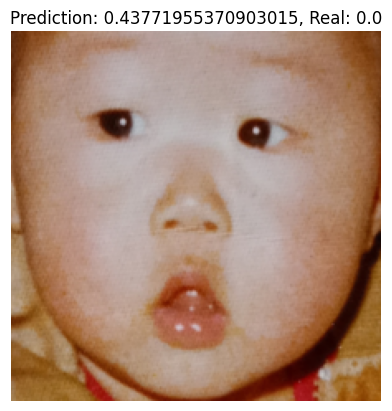

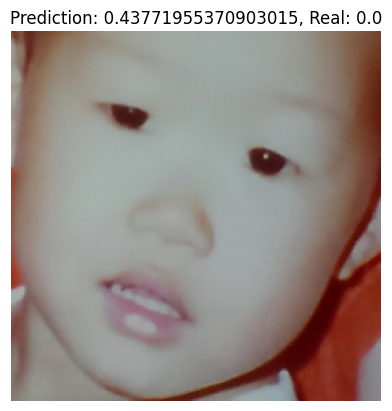

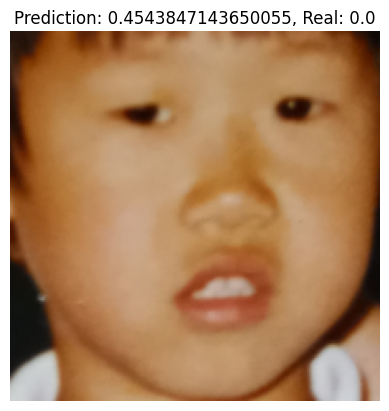

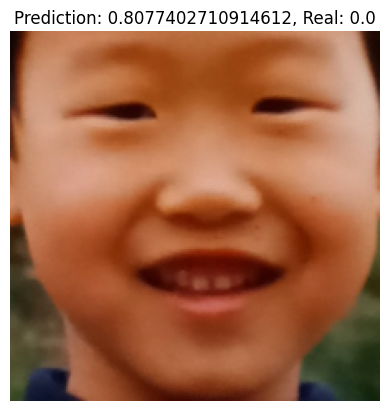

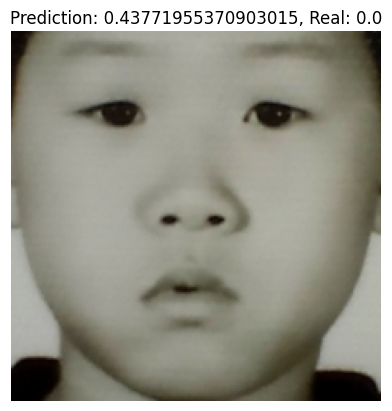

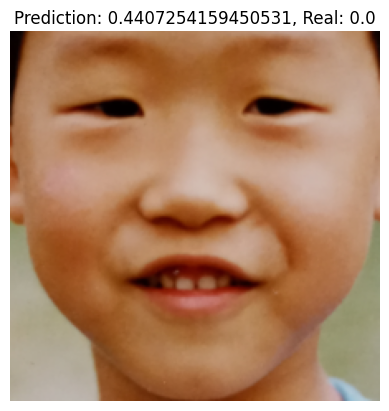

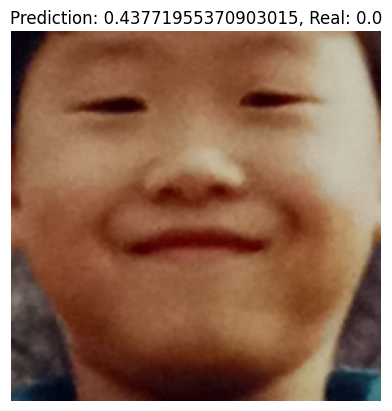

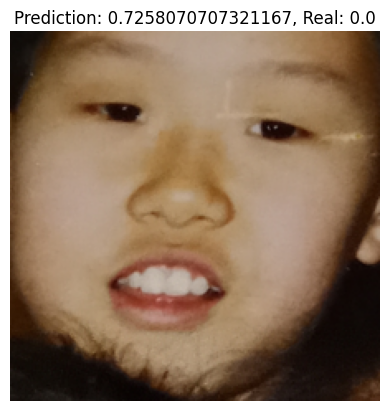

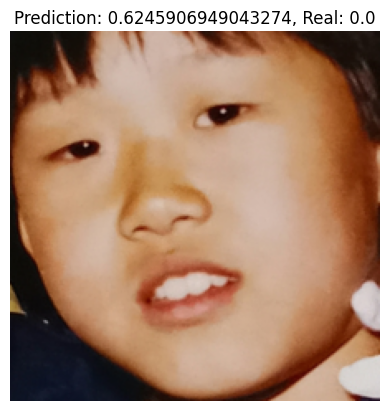

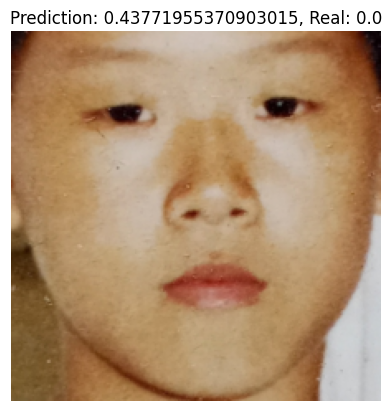

In [ ]:
for i in range(2550,2560):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

In [ ]:
def train_loop_gender(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    correct = 0  # 맞춘 개수 초기화
    total = 0     # 전체 개수 초기화
    start_time = time.time()  # 에포크 시작 시간

    for batch, (x, y) in enumerate(dataloader):
        batch_start_time = time.time()  # 배치 처리 시작 시간
        x, y = x.to(device), y['gender'].float().to(device)
        pred = model(x)
        loss = loss_fn(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 정확도 계산
        pred = torch.sigmoid(pred)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        total += y.size(0)
        correct += torch.sum(pred == y).item()

        batch_process_time = time.time() - batch_start_time

        if batch % 10 == 0:
            processed = (batch + 1) * len(x)
            print(f'Epoch {epoch+1} : [{processed} / {size}] loss : {loss.item()}, Batch time: {batch_process_time:.4f} sec')

    accuracy = 100 * correct / total  # 정확도 계산
    average_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} finished, Total Epoch time: {epoch_time:.4f} sec")
    return average_loss, accuracy

In [ ]:
def validation_loop_gender(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()

            # pred = torch.sigmoid(pred)
            _, predicted = torch.max(pred.unsqueeze(1), 1)
            total += y.size(0)
            correct += predicted.eq(y.long()).sum().item()

    accuracy = 100 * correct / total
    val_loss /= len(dataloader)
    return val_loss, accuracy

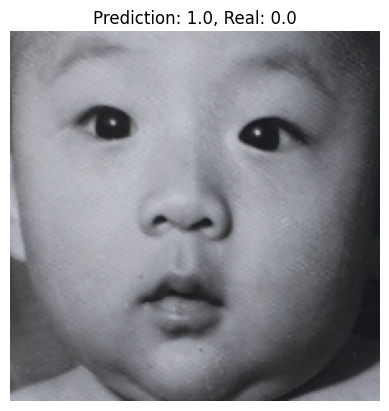

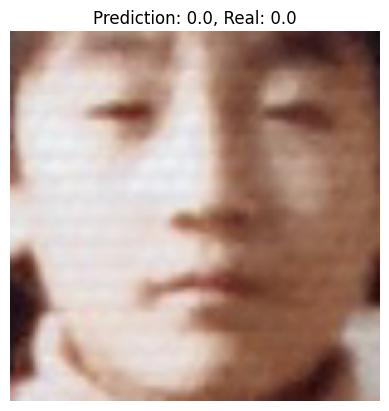

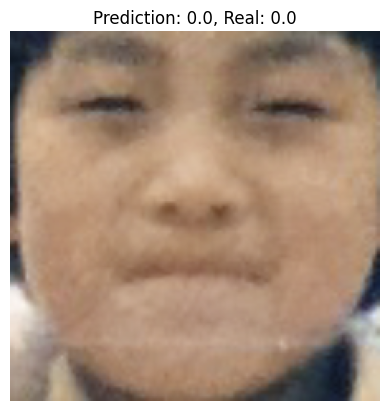

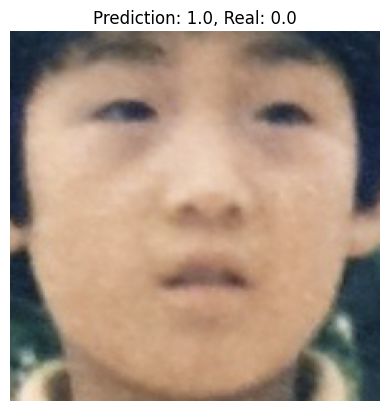

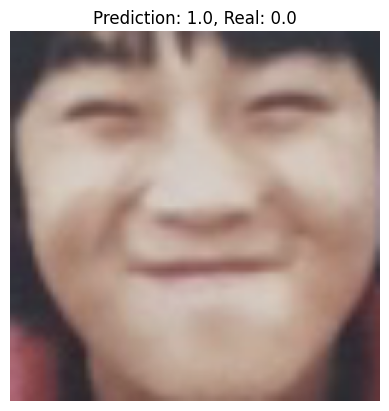

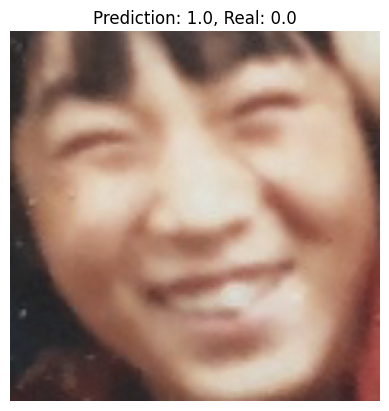

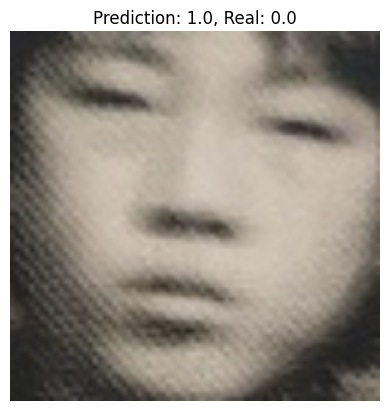

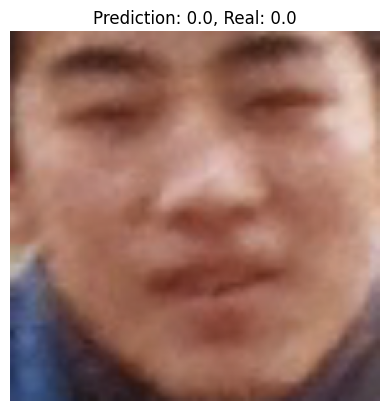

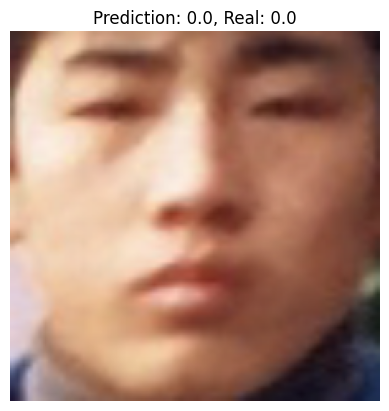

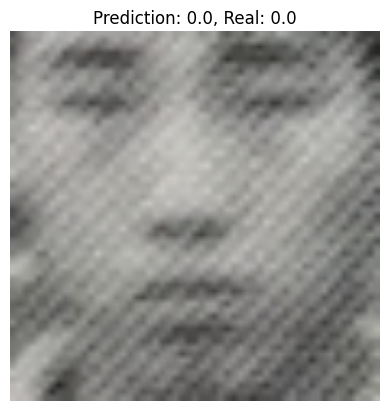

Validation Predictions: [0. 1. 1. ... 1. 1. 1.]
True Labels: [1. 1. 1. ... 1. 1. 1.]
Accuracy : 84.43564356435644


In [ ]:
def test_gender_prediction(dataloader, model, device):
    predictions = []
    true_labels = []
    images = []

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            pred = torch.sigmoid(pred)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0

            total += y.size(0)
            correct += torch.sum(pred == y).item()

            predictions.append(pred.cpu().numpy())
            true_labels.append(y.cpu().numpy())
            images.append(x.cpu().numpy())

    accuracy = 100 * correct / total
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    images = np.concatenate(images, axis=0)
    return predictions, true_labels, images, accuracy

gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v2_checkpoint_epoch_6.pth')
gender_model.to(device)
# validation 데이터로 성별 예측 수행
val_predictions, val_true_labels, val_images, val_accuracy = test_gender_prediction(val_loader, gender_model, device)

# 결과 출력

for i in range(2500,2510):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

print("Validation Predictions:", val_predictions)
print("True Labels:", val_true_labels)
print("Accuracy :", val_accuracy)

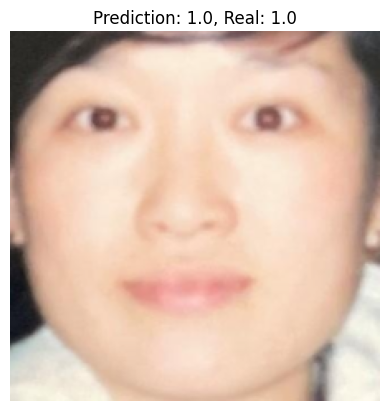

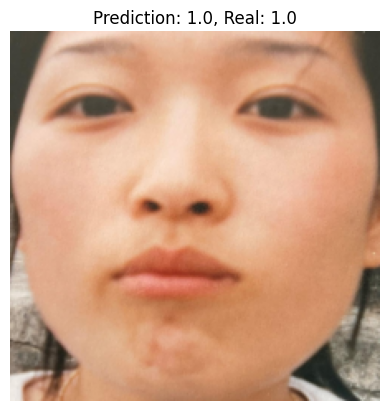

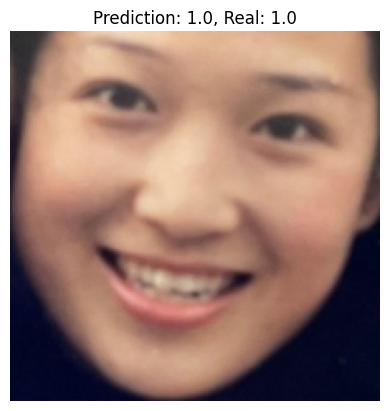

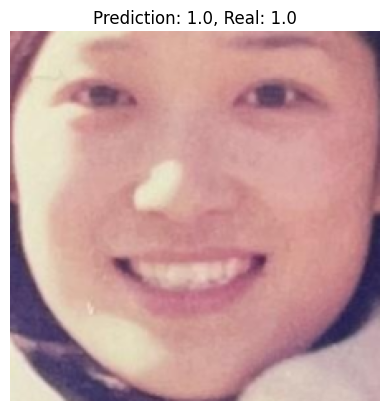

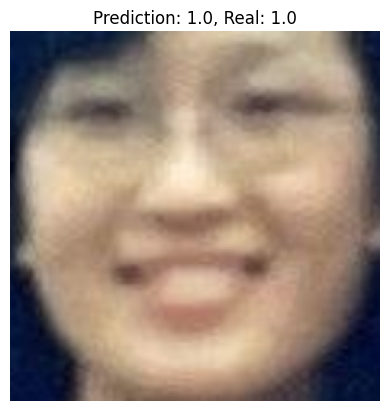

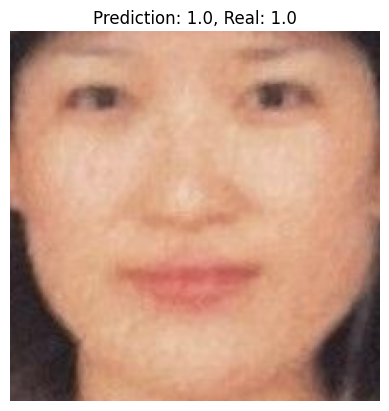

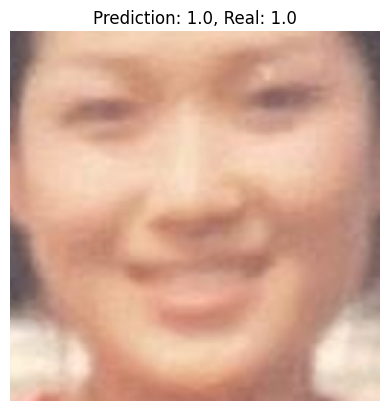

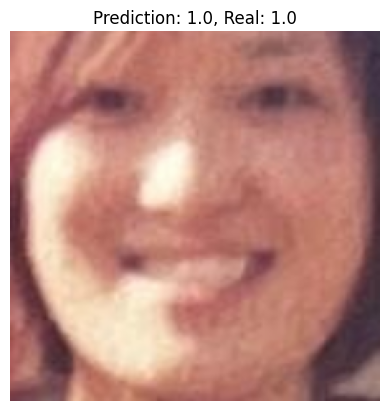

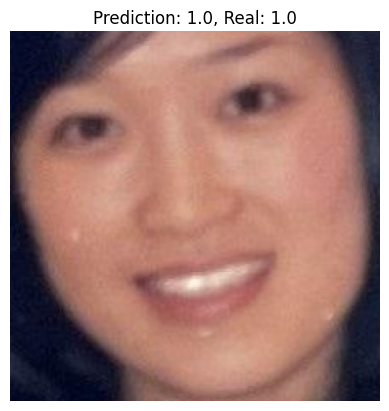

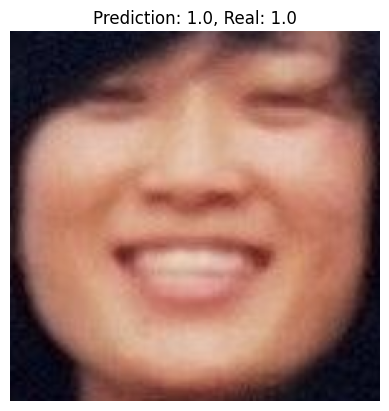

In [ ]:
for i in range(20,30):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

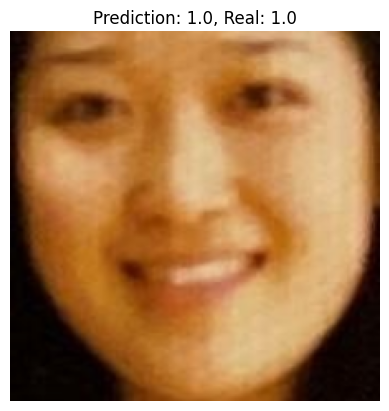

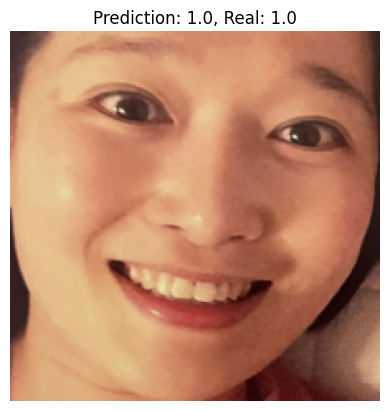

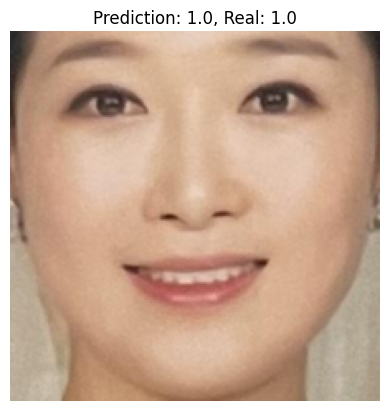

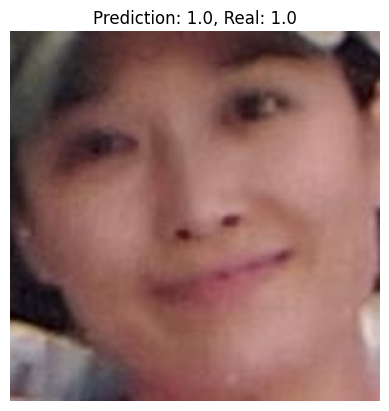

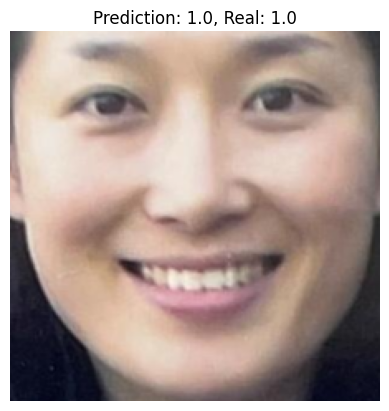

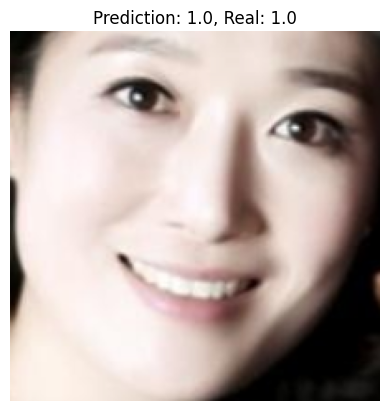

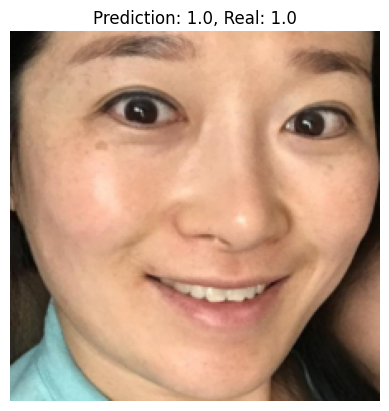

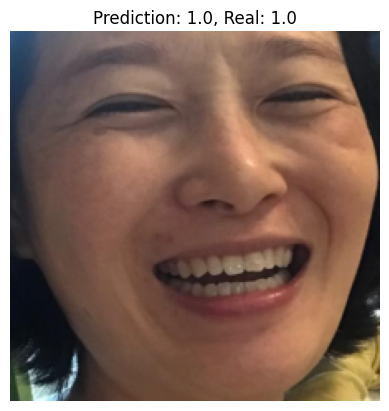

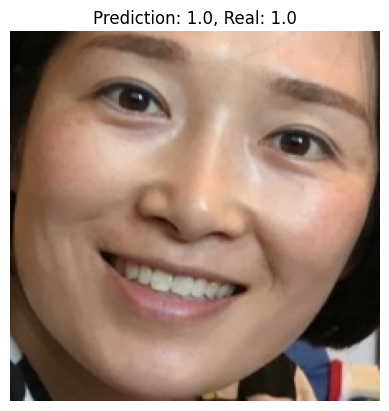

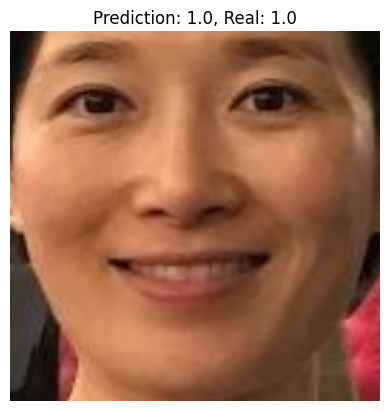

In [ ]:
for i in range(30,40):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

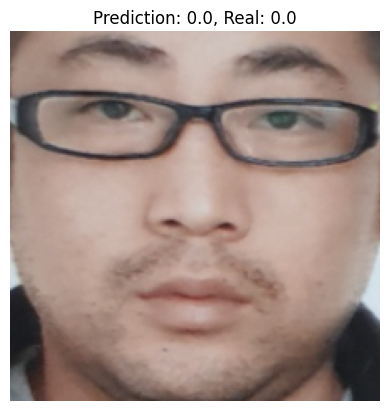

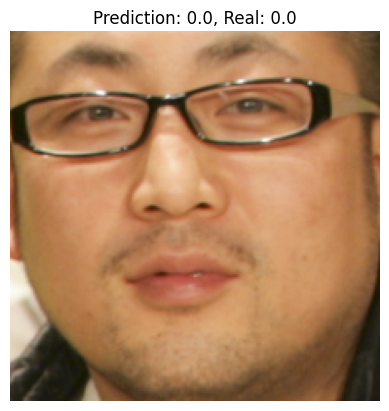

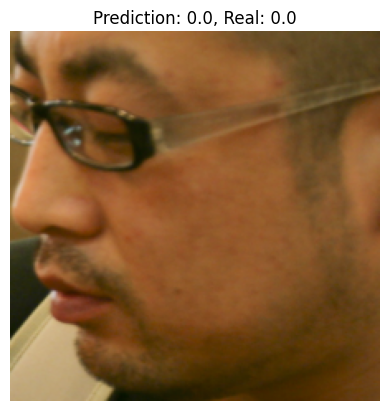

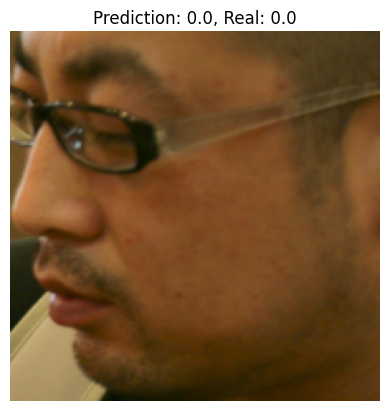

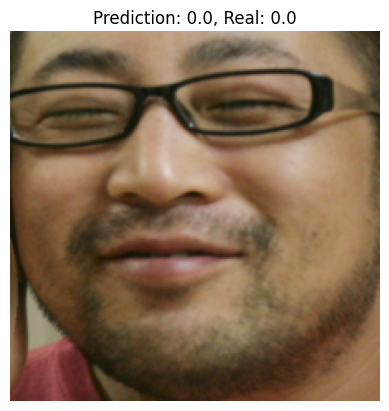

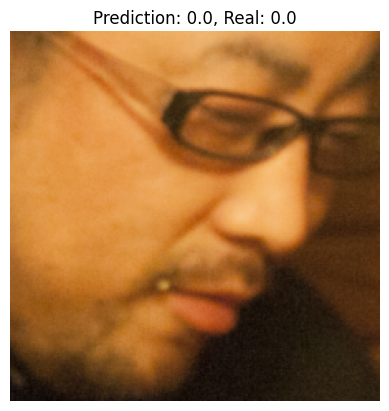

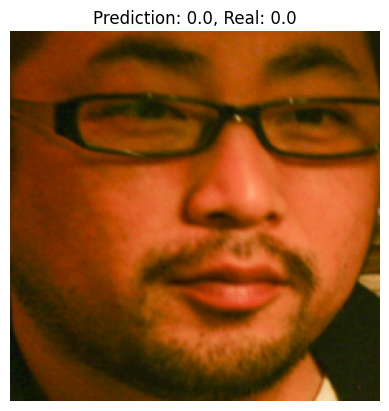

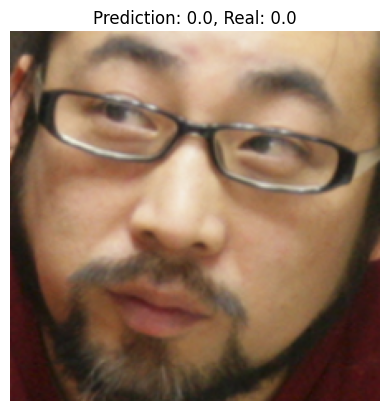

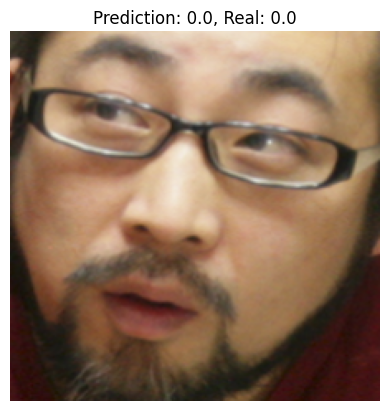

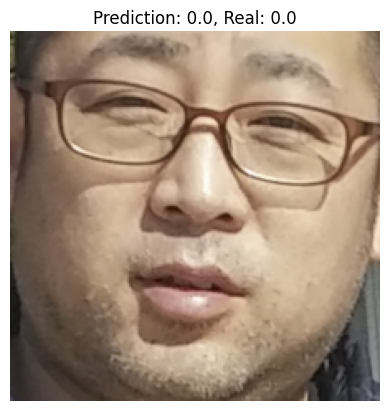

In [ ]:
for i in range(2530,2540):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

In [ ]:
start = time.time()
for epoch in range(30):
    gender_loss, gender_accuracy = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss, val_accuracy = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}, Accuracy: {gender_accuracy:.2f}%, Val_accuracy: {val_accuracy:.2f}%')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1 : [64 / 40150] loss : 0.7002058625221252, Batch time: 1.1628 sec
Epoch 1 : [704 / 40150] loss : 0.6603904962539673, Batch time: 0.1869 sec
Epoch 1 : [1344 / 40150] loss : 0.7204153537750244, Batch time: 0.1900 sec
Epoch 1 : [1984 / 40150] loss : 0.6038830280303955, Batch time: 0.1665 sec
Epoch 1 : [2624 / 40150] loss : 0.585545003414154, Batch time: 0.1556 sec
Epoch 1 : [3264 / 40150] loss : 0.6052415370941162, Batch time: 0.1665 sec
Epoch 1 : [3904 / 40150] loss : 0.5554779767990112, Batch time: 0.1614 sec
Epoch 1 : [4544 / 40150] loss : 0.5229825973510742, Batch time: 0.1685 sec
Epoch 1 : [5184 / 40150] loss : 0.5075780153274536, Batch time: 0.1583 sec
Epoch 1 : [5824 / 40150] loss : 0.6942666172981262, Batch time: 0.1743 sec
Epoch 1 : [6464 / 40150] loss : 0.667232871055603, Batch time: 0.1740 sec
Epoch 1 : [7104 / 40150] loss : 0.5734769105911255, Batch time: 0.1551 sec
Epoch 1 : [7744 / 40150] loss : 0.5193538665771484, Batch time: 0.1641 sec
Epoch 1 : [8384 / 40150] loss 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [15424 / 40150] loss : 0.5679664015769958, Batch time: 0.1536 sec
Epoch 1 : [16064 / 40150] loss : 0.609860360622406, Batch time: 0.1693 sec
Epoch 1 : [16704 / 40150] loss : 0.5697531700134277, Batch time: 0.1650 sec
Epoch 1 : [17344 / 40150] loss : 0.35701096057891846, Batch time: 0.1685 sec
Epoch 1 : [17984 / 40150] loss : 0.6261457204818726, Batch time: 0.1524 sec
Epoch 1 : [18624 / 40150] loss : 0.5327465534210205, Batch time: 0.1538 sec
Epoch 1 : [19264 / 40150] loss : 0.4597967267036438, Batch time: 0.1528 sec
Epoch 1 : [19904 / 40150] loss : 0.5489121675491333, Batch time: 0.1543 sec
Epoch 1 : [20544 / 40150] loss : 0.5181460380554199, Batch time: 0.1629 sec
Epoch 1 : [21184 / 40150] loss : 0.5358240604400635, Batch time: 0.1534 sec
Epoch 1 : [21824 / 40150] loss : 0.5000760555267334, Batch time: 0.1522 sec
Epoch 1 : [22464 / 40150] loss : 0.4194391965866089, Batch time: 0.1692 sec
Epoch 1 : [23104 / 40150] loss : 0.42961180210113525, Batch time: 0.1662 sec
Epoch 1 : [

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [25024 / 40150] loss : 0.43363916873931885, Batch time: 0.1766 sec
Epoch 1 : [25664 / 40150] loss : 0.43603941798210144, Batch time: 0.1627 sec
Epoch 1 : [26304 / 40150] loss : 0.4835062026977539, Batch time: 0.1635 sec
Epoch 1 : [26944 / 40150] loss : 0.4271063804626465, Batch time: 0.1567 sec
Epoch 1 : [27584 / 40150] loss : 0.5459184646606445, Batch time: 0.1522 sec
Epoch 1 : [28224 / 40150] loss : 0.31905341148376465, Batch time: 0.1598 sec
Epoch 1 : [28864 / 40150] loss : 0.4790171980857849, Batch time: 0.1580 sec
Epoch 1 : [29504 / 40150] loss : 0.39841073751449585, Batch time: 0.1833 sec
Epoch 1 : [30144 / 40150] loss : 0.39708709716796875, Batch time: 0.1537 sec
Epoch 1 : [30784 / 40150] loss : 0.47487038373947144, Batch time: 0.1763 sec
Epoch 1 : [31424 / 40150] loss : 0.4739013612270355, Batch time: 0.1917 sec
Epoch 1 : [32064 / 40150] loss : 0.46455955505371094, Batch time: 0.1976 sec
Epoch 1 : [32704 / 40150] loss : 0.4401146471500397, Batch time: 0.1895 sec
Epoch

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [1344 / 40150] loss : 0.43015098571777344, Batch time: 0.1871 sec
Epoch 2 : [1984 / 40150] loss : 0.5706806182861328, Batch time: 0.1983 sec
Epoch 2 : [2624 / 40150] loss : 0.44572412967681885, Batch time: 0.1675 sec
Epoch 2 : [3264 / 40150] loss : 0.4541490375995636, Batch time: 0.1599 sec
Epoch 2 : [3904 / 40150] loss : 0.425872266292572, Batch time: 0.1522 sec
Epoch 2 : [4544 / 40150] loss : 0.4378214478492737, Batch time: 0.1536 sec
Epoch 2 : [5184 / 40150] loss : 0.41656553745269775, Batch time: 0.1600 sec
Epoch 2 : [5824 / 40150] loss : 0.4817940890789032, Batch time: 0.1593 sec
Epoch 2 : [6464 / 40150] loss : 0.4039173722267151, Batch time: 0.1677 sec
Epoch 2 : [7104 / 40150] loss : 0.3905647397041321, Batch time: 0.1682 sec
Epoch 2 : [7744 / 40150] loss : 0.3685116469860077, Batch time: 0.1573 sec
Epoch 2 : [8384 / 40150] loss : 0.3738148808479309, Batch time: 0.1534 sec
Epoch 2 : [9024 / 40150] loss : 0.38418251276016235, Batch time: 0.1536 sec
Epoch 2 : [9664 / 4015

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [19264 / 40150] loss : 0.4777349531650543, Batch time: 0.1610 sec
Epoch 2 : [19904 / 40150] loss : 0.46698206663131714, Batch time: 0.1668 sec
Epoch 2 : [20544 / 40150] loss : 0.35583752393722534, Batch time: 0.1577 sec
Epoch 2 : [21184 / 40150] loss : 0.37937280535697937, Batch time: 0.1566 sec
Epoch 2 : [21824 / 40150] loss : 0.7154717445373535, Batch time: 0.1573 sec
Epoch 2 : [22464 / 40150] loss : 0.44193369150161743, Batch time: 0.1527 sec
Epoch 2 : [23104 / 40150] loss : 0.4194793701171875, Batch time: 0.1591 sec
Epoch 2 : [23744 / 40150] loss : 0.45111361145973206, Batch time: 0.1559 sec
Epoch 2 : [24384 / 40150] loss : 0.26133060455322266, Batch time: 0.1651 sec
Epoch 2 : [25024 / 40150] loss : 0.3984343707561493, Batch time: 0.1555 sec
Epoch 2 : [25664 / 40150] loss : 0.3183671534061432, Batch time: 0.1682 sec
Epoch 2 : [26304 / 40150] loss : 0.47692206501960754, Batch time: 0.1632 sec
Epoch 2 : [26944 / 40150] loss : 0.3296264410018921, Batch time: 0.1527 sec
Epoch

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [28224 / 40150] loss : 0.21663987636566162, Batch time: 0.1533 sec
Epoch 3 : [28864 / 40150] loss : 0.3468702435493469, Batch time: 0.1890 sec
Epoch 3 : [29504 / 40150] loss : 0.35479050874710083, Batch time: 0.1923 sec
Epoch 3 : [30144 / 40150] loss : 0.39150798320770264, Batch time: 0.1981 sec
Epoch 3 : [30784 / 40150] loss : 0.3269253075122833, Batch time: 0.1998 sec
Epoch 3 : [31424 / 40150] loss : 0.43548062443733215, Batch time: 0.1978 sec
Epoch 3 : [32064 / 40150] loss : 0.40311741828918457, Batch time: 0.1976 sec
Epoch 3 : [32704 / 40150] loss : 0.29924723505973816, Batch time: 0.1938 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [33344 / 40150] loss : 0.298370361328125, Batch time: 0.1980 sec
Epoch 3 : [33984 / 40150] loss : 0.2987610697746277, Batch time: 0.1937 sec
Epoch 3 : [34624 / 40150] loss : 0.3673097789287567, Batch time: 0.1997 sec
Epoch 3 : [35264 / 40150] loss : 0.3285457491874695, Batch time: 0.1992 sec
Epoch 3 : [35904 / 40150] loss : 0.3734401762485504, Batch time: 0.1978 sec
Epoch 3 : [36544 / 40150] loss : 0.3558739423751831, Batch time: 0.1884 sec
Epoch 3 : [37184 / 40150] loss : 0.36916297674179077, Batch time: 0.1942 sec
Epoch 3 : [37824 / 40150] loss : 0.37183916568756104, Batch time: 0.1983 sec
Epoch 3 : [38464 / 40150] loss : 0.3668977618217468, Batch time: 0.1929 sec
Epoch 3 : [39104 / 40150] loss : 0.28270912170410156, Batch time: 0.1980 sec
Epoch 3 : [39744 / 40150] loss : 0.3560129404067993, Batch time: 0.1984 sec
Epoch 3 finished, Total Epoch time: 1563.2650 sec, Accuracy: 44.08%
Validation Accuracy: 45.54%
Epoch : 3, Loss : 0.35940382359134165, Val_loss : 0.29983959054645

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 : [6464 / 40150] loss : 0.2541828751564026, Batch time: 0.1942 sec
Epoch 4 : [7104 / 40150] loss : 0.28684234619140625, Batch time: 0.1974 sec
Epoch 4 : [7744 / 40150] loss : 0.41369396448135376, Batch time: 0.1984 sec
Epoch 4 : [8384 / 40150] loss : 0.30057191848754883, Batch time: 0.1980 sec
Epoch 4 : [9024 / 40150] loss : 0.33115988969802856, Batch time: 0.1980 sec
Epoch 4 : [9664 / 40150] loss : 0.3276854157447815, Batch time: 0.1555 sec
Epoch 4 : [10304 / 40150] loss : 0.30910417437553406, Batch time: 0.1638 sec
Epoch 4 : [10944 / 40150] loss : 0.29076921939849854, Batch time: 0.1571 sec
Epoch 4 : [11584 / 40150] loss : 0.29783546924591064, Batch time: 0.1630 sec
Epoch 4 : [12224 / 40150] loss : 0.3164224624633789, Batch time: 0.1591 sec
Epoch 4 : [12864 / 40150] loss : 0.3211856484413147, Batch time: 0.1545 sec
Epoch 4 : [13504 / 40150] loss : 0.34107497334480286, Batch time: 0.1530 sec
Epoch 4 : [14144 / 40150] loss : 0.27582991123199463, Batch time: 0.1543 sec
Epoch 4 :

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 : [30144 / 40150] loss : 0.23024487495422363, Batch time: 0.1923 sec
Epoch 4 : [30784 / 40150] loss : 0.33091771602630615, Batch time: 0.1528 sec
Epoch 4 : [31424 / 40150] loss : 0.28203144669532776, Batch time: 0.1684 sec
Epoch 4 : [32064 / 40150] loss : 0.29770028591156006, Batch time: 0.1551 sec
Epoch 4 : [32704 / 40150] loss : 0.2377457618713379, Batch time: 0.1543 sec
Epoch 4 : [33344 / 40150] loss : 0.49927815794944763, Batch time: 0.1628 sec
Epoch 4 : [33984 / 40150] loss : 0.37563708424568176, Batch time: 0.1710 sec
Epoch 4 : [34624 / 40150] loss : 0.2965250611305237, Batch time: 0.1697 sec
Epoch 4 : [35264 / 40150] loss : 0.2869086265563965, Batch time: 0.1667 sec
Epoch 4 : [35904 / 40150] loss : 0.3121139407157898, Batch time: 0.1697 sec
Epoch 4 : [36544 / 40150] loss : 0.31127122044563293, Batch time: 0.1548 sec
Epoch 4 : [37184 / 40150] loss : 0.37370580434799194, Batch time: 0.1555 sec
Epoch 4 : [37824 / 40150] loss : 0.2504867911338806, Batch time: 0.1572 sec
Epoc

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 : [17344 / 40150] loss : 0.312125563621521, Batch time: 0.1532 sec
Epoch 5 : [17984 / 40150] loss : 0.45695480704307556, Batch time: 0.1656 sec
Epoch 5 : [18624 / 40150] loss : 0.29632145166397095, Batch time: 0.1613 sec
Epoch 5 : [19264 / 40150] loss : 0.43349581956863403, Batch time: 0.1684 sec
Epoch 5 : [19904 / 40150] loss : 0.3293384909629822, Batch time: 0.1662 sec
Epoch 5 : [20544 / 40150] loss : 0.37204986810684204, Batch time: 0.1686 sec
Epoch 5 : [21184 / 40150] loss : 0.2980054020881653, Batch time: 0.1644 sec
Epoch 5 : [21824 / 40150] loss : 0.33996719121932983, Batch time: 0.1541 sec
Epoch 5 : [22464 / 40150] loss : 0.25492188334465027, Batch time: 0.1694 sec
Epoch 5 : [23104 / 40150] loss : 0.3381441533565521, Batch time: 0.1610 sec
Epoch 5 : [23744 / 40150] loss : 0.3810151219367981, Batch time: 0.1541 sec
Epoch 5 : [24384 / 40150] loss : 0.2820158004760742, Batch time: 0.1532 sec
Epoch 5 : [25024 / 40150] loss : 0.2311275154352188, Batch time: 0.1550 sec
Epoch 5

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 : [39104 / 40150] loss : 0.3087086081504822, Batch time: 0.1653 sec
Epoch 5 : [39744 / 40150] loss : 0.36850705742836, Batch time: 0.1541 sec
Epoch 5 finished, Total Epoch time: 1608.4485 sec, Accuracy: 44.08%
Validation Accuracy: 45.54%
Epoch : 5, Loss : 0.31512831661636664, Val_loss : 0.31097990250851537, Accuracy: 44.08%, Val_accuracy: 45.54%
Epoch 6 : [64 / 40150] loss : 0.42066967487335205, Batch time: 0.1956 sec
Epoch 6 : [704 / 40150] loss : 0.4256751239299774, Batch time: 0.1984 sec
Epoch 6 : [1344 / 40150] loss : 0.2568379342556, Batch time: 0.1871 sec
Epoch 6 : [1984 / 40150] loss : 0.2865448594093323, Batch time: 0.1946 sec
Epoch 6 : [2624 / 40150] loss : 0.2463420033454895, Batch time: 0.1552 sec
Epoch 6 : [3264 / 40150] loss : 0.29477471113204956, Batch time: 0.1617 sec
Epoch 6 : [3904 / 40150] loss : 0.2512866258621216, Batch time: 0.1775 sec
Epoch 6 : [4544 / 40150] loss : 0.2931984066963196, Batch time: 0.1674 sec
Epoch 6 : [5184 / 40150] loss : 0.37723135948181

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 : [25664 / 40150] loss : 0.2213517725467682, Batch time: 0.1967 sec
Epoch 6 : [26304 / 40150] loss : 0.21911969780921936, Batch time: 0.1982 sec
Epoch 6 : [26944 / 40150] loss : 0.28339678049087524, Batch time: 0.1980 sec
Epoch 6 : [27584 / 40150] loss : 0.25721991062164307, Batch time: 0.1954 sec
Epoch 6 : [28224 / 40150] loss : 0.30043908953666687, Batch time: 0.2002 sec
Epoch 6 : [28864 / 40150] loss : 0.22496923804283142, Batch time: 0.1868 sec
Epoch 6 : [29504 / 40150] loss : 0.4937882721424103, Batch time: 0.1949 sec
Epoch 6 : [30144 / 40150] loss : 0.3136310279369354, Batch time: 0.1944 sec
Epoch 6 : [30784 / 40150] loss : 0.2645539343357086, Batch time: 0.2004 sec
Epoch 6 : [31424 / 40150] loss : 0.2822261452674866, Batch time: 0.1985 sec
Epoch 6 : [32064 / 40150] loss : 0.2096128761768341, Batch time: 0.1959 sec
Epoch 6 : [32704 / 40150] loss : 0.298865407705307, Batch time: 0.1909 sec
Epoch 6 : [33344 / 40150] loss : 0.4545837342739105, Batch time: 0.1972 sec
Epoch 6 

KeyboardInterrupt: 

- Epoch : 1, Loss : 0.5026008552236921, Val_loss : 0.4674195149748386
- Epoch : 2, Loss : 0.4038433289736699, Val_loss : 0.3468939490333388
- Epoch : 3, Loss : 0.35940382359134165, Val_loss : 0.29983959054645104
- Epoch : 4, Loss : 0.3308286448098292, Val_loss : 0.28946697495028945
- Epoch : 5, Loss : 0.31512831661636664, Val_loss : 0.31097990250851537
- Epoch : 6, Loss : 0.2961135737265751, Val_loss : 0.2772967546140846

In [ ]:
# 모델과 옵티마이저 초기화
gender_model = Gender_Net().to(device)
opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)

# 체크포인트 불러오기
gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_5.pth')

# 학습 재개
start = time.time()
for epoch in range(start_epoch + 1, start_epoch + 28):
    gender_loss = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}, Accuracy: {gender_accuracy:.2f}%, Val_accuracy: {val_accuracy:.2f}%')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_5.pth')
gender_model.to(device)
# validation 데이터로 성별 예측 수행
val_predictions, val_true_labels, val_images, val_accuracy = test_gender_prediction(val_loader, gender_model, device)

# 결과 출력

# for i in range(2500,2510):
#   image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
#   mean = np.array([0.6284, 0.4901, 0.4325])
#   std = np.array([0.1869, 0.1712, 0.1561])
#   image = std * image + mean
#   image = np.clip(image, 0, 1)
#   plt.imshow(image)
#   plt.axis('off')
#   plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
#   plt.show()

print("Validation Predictions:", val_predictions)
print("True Labels:", val_true_labels)
print("Accuracy :", val_accuracy)

Validation Predictions: [1. 1. 1. ... 1. 1. 1.]
True Labels: [1. 1. 1. ... 1. 1. 1.]
Accuracy : 84.91089108910892
